## Практическое задание

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip install stop-words pymorphy2
from string import punctuation
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 408.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 12.1 MB/s eta 0:00:00


In [2]:
# вспомогательные функции

# функция преобразования текста
def preprocess_text(txt):
    txt = str(txt)    
    txt = ''.join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [stemmer.stem(word) for word in txt.split() if word not in sw]
    txt = [lemmatizer.lemmatize(word) for word in txt]
    return ' '.join(txt)


# функция превращения текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

## Загрузка данных

In [3]:
# зададим параметры

max_words = 3000
max_len = 30
num_classes = 1

# обучение
epochs = 10
batch_size = 256
print_batch_n = 100

In [4]:
# прочитаем данные
train_data = pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/train.csv')
# test_data = pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/test.csv')

train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
# разделим данные на тренировочную и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_data['label'], test_size=0.2, random_state=42)
X_train.drop('label', axis=1, inplace=True)
X_valid.drop('label', axis=1, inplace=True)

In [6]:
print(f'Train shapes: {X_train.shape}, {y_train.shape}')
print(f'Valid shapes: {X_valid.shape}, {y_valid.shape}')
# print(f'Test shape: {test_data.shape}')

Train shapes: (25569, 2), (25569,)
Valid shapes: (6393, 2), (6393,)


In [7]:
# label 1 - the tweet is racist/sexist
# label 0 - the tweet is NOT racist/sexist

y_train.value_counts()

0    23783
1     1786
Name: label, dtype: int64

## Предобработка данных

In [8]:
# создадим множество стоп-слов для английского языка
sw = set(get_stop_words('en'))
# print(sw)

# создадим множество с пунктуацией
puncts = set(punctuation)
# print(puncts)

# сделаем стемминг (уберем лишние куски слова)
stemmer = PorterStemmer()
print(f"stemmer: dysfunctional --> {stemmer.stem('dysfunctional')}")

# сделаем лемматизацию
lemmatizer = WordNetLemmatizer()
print(f"lemmatizer: makes --> {lemmatizer.lemmatize('makes')}")

stemmer: dysfunctional --> dysfunct
lemmatizer: makes --> make


In [9]:
# посмотрим пример твита
X_train['tweet'].iloc[:1].values

array(["@user @user @user because i've been paying attention for the past year/8 years. he's a â\x80¦ "],
      dtype=object)

In [10]:
# твит после обработки
X_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['user user user ive pay attent past year8 year he â\x80¦'],
      dtype=object)

In [11]:
# обработаем данные
tqdm.pandas()

X_train['tweet'] = X_train['tweet'].progress_apply(preprocess_text)
X_valid['tweet'] = X_valid['tweet'].progress_apply(preprocess_text)
# test_data['tweet'] = test_data['tweet'].progress_apply(preprocess_text)

100%|██████████| 6393/6393 [00:02<00:00, 2592.94it/s]


In [12]:
# соединим все слова вместе
train_corpus = " ".join(X_train["tweet"])
train_corpus = train_corpus.lower()

# сделаем токенизацию
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
print(tokens[:5])

# отфильтруем токены (проверим все символы, что они являются буквенно-цифровыми)
tokens_filtered = [word for word in tokens if word.isalnum()]

# посчитаем количество повторений каждого слова
dist = FreqDist(tokens_filtered)

# берем топ 3000
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
print(len(tokens_filtered_top))
print(tokens_filtered_top[:10])

# составим словарь
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# print(vocabulary)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['user', 'user', 'user', 'ive', 'pay']
2999
['user', 'love', 'day', 'happi', 'u', 'amp', 'thank', 'just', 'will', 'get']


In [13]:
%%time

# преобразуем тексты в последовательности
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train['tweet']])
X_valid = np.asarray([text_to_sequence(text, max_len) for text in X_valid['tweet']])
# test_data = np.asarray([text_to_sequence(text, max_len) for text in test_data['tweet']])

CPU times: user 5.74 s, sys: 25.7 ms, total: 5.77 s
Wall time: 5.77 s


## Создание модели LSTM

In [14]:
# класс для создания кастомного датасета

class DataWrapper(Dataset):
    
    
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        self.transform = transform
        if target is None:
            self.target = torch.FloatTensor([])
        else:      
            self.target = torch.from_numpy(target).long()  
        
                
    def __getitem__(self, index):     
        x = self.data[index]  
        
        if self.transform:
            x = self.transform(x)

        if self.target.shape[0] == 0:
            return x
        else:                
            y = self.target[index]
            return x, y

    
    def __len__(self):
        
        return len(self.data)

In [15]:
# загрузим данные для модели

train_dataset = DataWrapper(X_train, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(X_valid, y_valid.values)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [16]:
for x, l in train_loader:
    
    print(x.shape)
    print(l.shape)
    print(l[0])
    
    break

torch.Size([256, 30])
torch.Size([256])
tensor(0)


In [17]:
# проверим наличие GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
# класс LSTM

class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim*2, num_layers=2, batch_first=True)
        self.linear_1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 1)        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear_1(last_tensor)
        out = torch.relu(out)
#         out = self.dropout(out)
        
        out = self.linear_2(out)
        
        return torch.sigmoid(out)

## Обучение модели LSTM

In [19]:
# зададим оптимизатор, критерий и инициализируем модель

# print(torch.seed())
torch.manual_seed(1502745103923699422)
lstm_init = LSTMFixedLen(max_words, 128, 128, use_last=False)
print(torch.initial_seed())
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

# обучим модель

lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

1502745103923699422
LSTMFixedLen(
  (embeddings): Embedding(3000, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (linear_1): Linear(in_features=256, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 1338625
Epoch [1/10]. Step [100/100]. Loss: 0.188. Acc: 0.922. Test loss: 0.038. Test acc: 0.939
Epoch [2/10]. Step [100/100]. Loss: 0.219. Acc: 0.943. Test loss: 0.153. Test acc: 0.949
Epoch [3/10]. Step [100/100]. Loss: 0.112. Acc: 0.949. Test loss: 0.024. Test acc: 0.952
Epoch [4/10]. Step [100/100]. Loss: 0.166. Acc: 0.956. Test loss: 0.306. Test acc: 0.945
Epoch [5/10]. Step [100/100]. Loss: 0.075. Acc: 0.962. Test loss: 0.001. Test acc: 0.953
Epoch [6/10]. Step [100/100]. Loss: 0.079. Acc: 0.966. Test loss: 0.004. Test acc: 0.956
Epoch [7/10]. Step [100/100]. Loss: 0.120. Acc: 0.969. Test loss: 0.001. Test acc: 0.957
Epoch [8/10]. Step [100/100]. Loss: 0

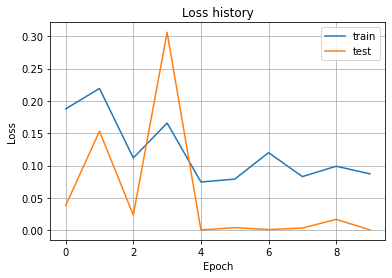

In [20]:
# визуализируем историю ошибки

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

In [21]:
# НАЧАЛЬНЫЕ ПАРАМЕТРЫ

# max_words = 3000
# max_len = 30
# num_classes = 1
# epochs = 10
# batch_size = 256
# print_batch_n = 100
# lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
# optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
#
# Epoch [10/10]. Step [100/100]. Loss: 0.081. Acc: 0.970. Test loss: 0.003. Test acc: 0.954

# + СЛОЙ lstm
# self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, batch_first=True)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.057. Acc: 0.970. Test loss: 0.241. Test acc: 0.951

# УВЕЛИЧИМ embedding_dim
# lstm_init = LSTMFixedLen(max_words, 256, 20, use_last=False)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.079. Acc: 0.975. Test loss: 0.009. Test acc: 0.952

# УМЕНЬШИМ embedding_dim
# lstm_init = LSTMFixedLen(max_words, 64, 20, use_last=False)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.076. Acc: 0.966. Test loss: 0.004. Test acc: 0.952

# УВЕЛИЧИМ hidden_dim
# lstm_init = LSTMFixedLen(max_words, 128, 128, use_last=False)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.061. Acc: 0.982. Test loss: 0.009. Test acc: 0.957

# УМЕНЬШИМ max_len
# max_len = 20
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.066. Acc: 0.984. Test loss: 0.000. Test acc: 0.955

# УМЕНЬШИМ max_words
# max_words = 2000
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.063. Acc: 0.978. Test loss: 0.008. Test acc: 0.953

# УВЕЛИЧИМ learning_rate
# optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.005)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.112. Acc: 0.988. Test loss: 0.005. Test acc: 0.947


# УМЕНЬШИМ learning_rate
# optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.0005)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.080. Acc: 0.976. Test loss: 0.001. Test acc: 0.949

# + СЛОЙ linear
# out = self.linear_1(last_tensor)
# out = torch.relu(out)
# out = self.dropout(out)
# out = self.linear_2(out)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.089. Acc: 0.977. Test loss: 0.001. Test acc: 0.958

## Вывод

С помощью итоговой модели LSTM удалось достичь точности на трейне около **0.977**, на валидации около - **0.958** (Через свертку получалось для сравнения на валидации **0.957**).

Точность повысилась благодаря увеличению размерности скрытых слоев. Был добавлен 1 плотный слой (+ Relu и Dropout).

## Создание модели GRU

In [22]:
# класс GRU

class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim*2, num_layers=3, batch_first=True)
        self.linear_1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 1) 
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
        
        out = self.linear_1(last_tensor)
        out = torch.relu(out)

        out = self.linear_2(out)

        return torch.sigmoid(out)

In [23]:
# зададим оптимизатор, критерий и инициализируем модель

# print(torch.seed())
torch.manual_seed(10804831423555468509)
gru_init = GRUFixedLen(max_words, 256, 128, use_last=False)
print(torch.initial_seed())
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

# обучим модель

gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

10804831423555468509
GRUFixedLen(
  (embeddings): Embedding(3000, 256, padding_idx=0)
  (gru): GRU(256, 256, num_layers=3, batch_first=True)
  (linear_1): Linear(in_features=256, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 1985281
Epoch [1/10]. Step [100/100]. Loss: 0.124. Acc: 0.931. Test loss: 0.023. Test acc: 0.948
Epoch [2/10]. Step [100/100]. Loss: 0.155. Acc: 0.952. Test loss: 0.175. Test acc: 0.949
Epoch [3/10]. Step [100/100]. Loss: 0.101. Acc: 0.961. Test loss: 0.029. Test acc: 0.952
Epoch [4/10]. Step [100/100]. Loss: 0.050. Acc: 0.966. Test loss: 0.001. Test acc: 0.952
Epoch [5/10]. Step [100/100]. Loss: 0.102. Acc: 0.971. Test loss: 0.002. Test acc: 0.956
Epoch [6/10]. Step [100/100]. Loss: 0.103. Acc: 0.975. Test loss: 0.009. Test acc: 0.957
Epoch [7/10]. Step [100/100]. Loss: 0.056. Acc: 0.980. Test loss: 0.001. Test acc: 0.952
Epoch [8/10]. Step [100/100]. Loss: 0.0

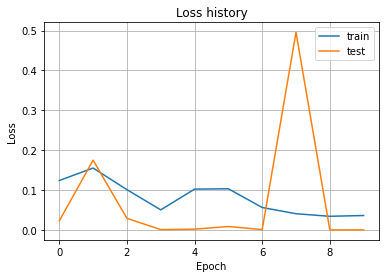

In [24]:
# визуализируем историю ошибки

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

In [25]:
# НАЧАЛЬНЫЕ ПАРАМЕТРЫ

# max_words = 3000
# max_len = 30
# num_classes = 1
# epochs = 10
# batch_size = 256
# print_batch_n = 100
# gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
# optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
#
# Epoch [10/10]. Step [100/100]. Loss: 0.140. Acc: 0.970. Test loss: 0.004. Test acc: 0.953

# + СЛОЙ gru
# self.gru = nn.GRU( embedding_dim, hidden_dim, num_layers=3, batch_first=True)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.057. Acc: 0.971. Test loss: 0.011. Test acc: 0.953

# УВЕЛИЧИМ embedding_dim
# gru_init = GRUFixedLen(max_words, 256, 20, use_last=False)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.110. Acc: 0.975. Test loss: 0.008. Test acc: 0.954

# УВЕЛИЧИМ hidden_dim
# gru_init = GRUFixedLen(max_words, 256, 128, use_last=False)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.022. Acc: 0.989. Test loss: 0.000. Test acc: 0.956

# УВЕЛИЧИМ learning_rate
# optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.005)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.016. Acc: 0.991. Test loss: 0.000. Test acc: 0.953


# УМЕНЬШИМ learning_rate
# optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.0001)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.127. Acc: 0.962. Test loss: 0.045. Test acc: 0.952

# + СЛОЙ linear
# out = self.linear_1(last_tensor)
# out = torch.relu(out)
# out = self.dropout(out)
# out = self.linear_2(out)
# 
# Epoch [10/10]. Step [100/100]. Loss: 0.027. Acc: 0.989. Test loss: 0.000. Test acc: 0.956

## Вывод

С помощью итоговой модели GRU удалось достичь точности на трейне около **0.989**, на валидации около - **0.958** (Через свертку получалось для сравнения на валидации **0.957**).

Точность повысилась благодаря увеличению размерности эмбеддинга, скрытых слоев. Был добавлен 1 плотный слой (+ Relu).

In [26]:
# класс GRU и LSTM

class GRULSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim*2, num_layers=3, batch_first=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim*2, num_layers=2, batch_first=True)

        self.linear_1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 1) 
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht_ = self.lstm(x)
        
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
        
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
        
        out = self.linear_1(last_tensor)
        out = torch.relu(out)
        out = self.dropout(out)

        out = self.linear_2(out)

        return torch.sigmoid(out)

In [27]:
# зададим оптимизатор, критерий и инициализируем модель

# print(torch.seed())
torch.manual_seed(15199617254667083002)
grulstm_init = GRULSTMFixedLen(max_words, 256, 128, use_last=True)
print(torch.initial_seed())
optimizer = torch.optim.Adam(grulstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

print(grulstm_init)
print("Parameters:", sum([param.nelement() for param in grulstm_init.parameters()]))

# обучим модель

gru_init = grulstm_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

15199617254667083002
GRULSTMFixedLen(
  (embeddings): Embedding(3000, 256, padding_idx=0)
  (gru): GRU(256, 256, num_layers=3, batch_first=True)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (linear_1): Linear(in_features=256, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 3037953
Epoch [1/10]. Step [100/100]. Loss: 0.222. Acc: 0.929. Test loss: 0.026. Test acc: 0.929
Epoch [2/10]. Step [100/100]. Loss: 0.156. Acc: 0.948. Test loss: 0.011. Test acc: 0.950
Epoch [3/10]. Step [100/100]. Loss: 0.101. Acc: 0.956. Test loss: 0.461. Test acc: 0.950
Epoch [4/10]. Step [100/100]. Loss: 0.099. Acc: 0.963. Test loss: 0.540. Test acc: 0.953
Epoch [5/10]. Step [100/100]. Loss: 0.041. Acc: 0.968. Test loss: 0.001. Test acc: 0.956
Epoch [6/10]. Step [100/100]. Loss: 0.093. Acc: 0.972. Test loss: 0.000. Test acc: 0.956
Epoch [7/10]. Step [100/100]. Loss: 0.135. Acc: 0.975. Test loss: 0

## Вывод

Модели LSTM, GRU и совмещенные их слои отрабатывают примерно одинаково. При этом было важно выбрать наилучшие веса для фиксирования точности повыше.